<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/03-31-2020.csv"

#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/
#csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [7]:
us_pop = 329968629  #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affecte: {(res.positive+res.death)/us_pop*100:2f}%")

positive     210770
negative     939190
pending       59687
death          4700
total       1209647
dtype: int64
Current Infection Rate 17.424091%
Percentage of US affecte: 0.065300%


In [8]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,83712,137168
34,NJ,22255,30387
24,MI,9334,11893
5,CA,8155,21772
21,MA,7738,44000
16,IL,6980,33404
10,FL,6955,59529
20,LA,6424,39352
41,PA,5805,42427
52,WA,5634,60566


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [10]:
dfUSAPos[-7:]

,date,positive,PCT
22,20200326,80735,0.383048
23,20200327,99413,0.471666
24,20200328,118234,0.560962
25,20200329,139061,0.659776
26,20200330,160530,0.761636
27,20200331,184770,0.876643
28,20200401,210770,1.000000


In [11]:
dfCAPos[-7:]

,date,positive,PCT
22,20200326,3006,0.368608
23,20200327,3879,0.475659
24,20200328,4643,0.569344
25,20200329,5708,0.699939
26,20200330,6447,0.790558
27,20200331,7482,0.917474
28,20200401,8155,1.000000


In [12]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200328,118234,617470,65712,16729.0,1965,801416,735704,435.0,3012.0,90250.0,18821.0,109071.0
20200329,139061,692290,65549,19730.0,2428,896900,831351,463.0,3001.0,74820.0,20827.0,95647.0
20200330,160530,784324,65382,22303.0,2939,1010236,944854,511.0,2573.0,92034.0,21469.0,113503.0
20200331,184770,864201,59529,26660.0,3746,1108500,1048971,807.0,4357.0,79877.0,24240.0,104117.0
20200401,210770,939190,59687,31142.0,4700,1209647,1149960,954.0,4482.0,74989.0,26000.0,100989.0


In [13]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200328,4643,20549,64400,1034.0,101,89592,25192,23.0,288.0,3169.0,764.0,3933.0
20200329,5708,20549,64400,1034.0,123,90657,26257,22.0,0.0,0.0,1065.0,1065.0
20200330,6447,20549,64400,1432.0,133,91396,26996,10.0,398.0,0.0,739.0,739.0
20200331,7482,21772,57400,1617.0,153,86654,29254,20.0,185.0,1223.0,1035.0,2258.0
20200401,8155,21772,57400,1855.0,171,87327,29927,18.0,238.0,0.0,673.0,673.0


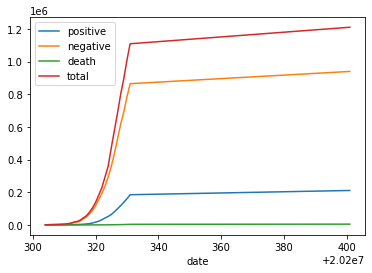

In [14]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [15]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
20200319,7087,100
20200320,10442,150
20200321,15219,201
20200322,15219,201
20200323,31573,402
20200324,42164,471
20200325,51914,673
20200326,63570,884
20200327,68334,991


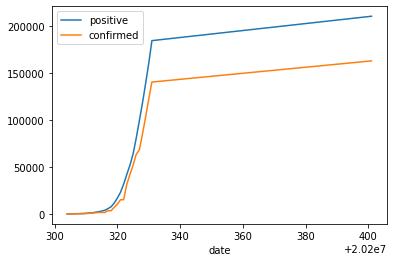

In [16]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [17]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200326,3006,17380,57400,0.0,65,77786,20386,12.0,0.0,1459.0,651.0,2110.0
20200327,3879,17380,57400,746.0,78,78659,21259,13.0,746.0,0.0,873.0,873.0
20200328,4643,20549,64400,1034.0,101,89592,25192,23.0,288.0,3169.0,764.0,3933.0
20200329,5708,20549,64400,1034.0,123,90657,26257,22.0,0.0,0.0,1065.0,1065.0
20200330,6447,20549,64400,1432.0,133,91396,26996,10.0,398.0,0.0,739.0,739.0
20200331,7482,21772,57400,1617.0,153,86654,29254,20.0,185.0,1223.0,1035.0,2258.0
20200401,8155,21772,57400,1855.0,171,87327,29927,18.0,238.0,0.0,673.0,673.0


In [18]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    188172
dead           3873
dtype: int64

In [19]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    8210
dead          173
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [21]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                188172
Italy             105792
Spain              95923
China              82279
Germany            71808
France             52827
Iran               44605
United Kingdom     25481
Switzerland        16605
Turkey             13531
Name: confirmed, dtype: int64

In [22]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(20)

country
US                188172
Italy             105792
Spain              95923
China              82279
Germany            71808
France             52827
Iran               44605
United Kingdom     25481
Switzerland        16605
Turkey             13531
Belgium            12775
Netherlands        12667
Austria            10180
Korea, South        9786
Canada              8527
Portugal            7443
Brazil              5717
Israel              5358
Norway              4641
Australia           4559
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [27]:
dfState.loc['FL'].head(7)

,date,positive,current_total,pct
state,,,,
FL,20200401,6955,6955,1.000000
FL,20200331,6338,6955,0.911287
FL,20200330,5473,6955,0.786916
FL,20200329,4246,6955,0.610496
FL,20200328,3763,6955,0.541050
FL,20200327,2765,6955,0.397556
FL,20200326,2355,6955,0.338605


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

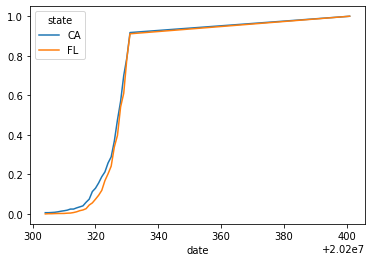

In [29]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

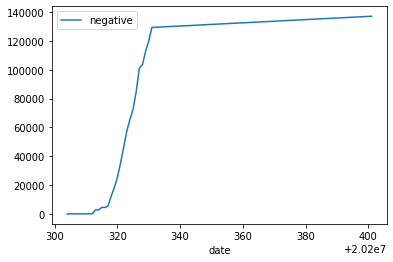

In [31]:
x = dfNYTesting.plot.line()

In [32]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,current_total,pct
264,FL,20200401,6955,6955,1.000000
265,FL,20200331,6338,6955,0.911287
266,FL,20200330,5473,6955,0.786916
267,FL,20200329,4246,6955,0.610496
268,FL,20200328,3763,6955,0.541050
269,FL,20200327,2765,6955,0.397556
270,FL,20200326,2355,6955,0.338605
271,FL,20200325,1682,6955,0.241840
272,FL,20200324,1412,6955,0.203019
273,FL,20200323,1171,6955,0.168368


In [33]:
datecutoff = int(((pd.to_datetime(str(dfDates.date.max())))-datetime.timedelta(days=3)).strftime("%Y%m%d"))
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .60)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
640,MI,20200329,5486,9334,0.587744
531,LA,20200329,3540,6424,0.551059
1097,PA,20200329,3394,5805,0.584668
296,GA,20200329,2651,4638,0.571583
186,CT,20200329,1993,3557,0.560304
1222,TN,20200329,1537,2683,0.572866
450,IN,20200329,1514,2565,0.590253
1305,VA,20200329,890,1484,0.599730
695,MO,20200329,838,1581,0.530044
1167,SC,20200329,774,1293,0.598608


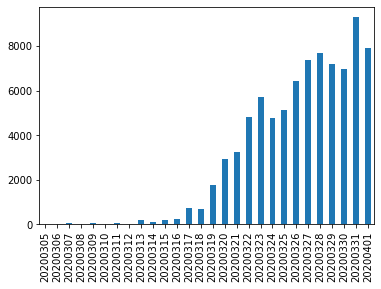

In [39]:
state = 'NY'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfStateData = pd.read_csv(data_url)

In [37]:
dfStateData[dfStateData.STATE >0][['STATE','NAME', 'POPESTIMATE2019']]

,STATE,NAME,POPESTIMATE2019
5,1,Alabama,4903185
6,2,Alaska,731545
7,4,Arizona,7278717
8,5,Arkansas,3017804
9,6,California,39512223
10,8,Colorado,5758736
11,9,Connecticut,3565287
12,10,Delaware,973764
13,11,District of Columbia,705749
14,12,Florida,21477737


In [38]:
dfStateData[dfStateData.STATE ==0][['STATE','NAME', 'POPESTIMATE2019']]

,STATE,NAME,POPESTIMATE2019
0,0,United States,328239523
1,0,Northeast Region,55982803
2,0,Midwest Region,68329004
3,0,South Region,125580448
4,0,West Region,78347268
